In [1]:
import numpy as np
from cleanrl.ppo_continuous_action import Agent
from envs.shell import shell
from envs.asu.env import make_asu_env
from cleanrl.ppo_continuous_action import make_env
import gymnasium as gym
import torch
import matplotlib.pyplot as plt 
import argparse
import os 
from envs.parafoil.simple_env import Parafoil

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--qr", metavar=('q', 'r'), type=float, nargs=2, default=(1, 1),
        help="The (q, r) pair value for Shell env")
args = parser.parse_known_args()[0]


envs_eval = gym.vector.SyncVectorEnv(
    [make_env(1, i, False, 1, 0.99, args) for i in range(10)])

# q = envs_eval.envs[0].q
# r = envs_eval.envs[0].r
# print(q, r)

In [47]:
pos = [] 
du = [] 

envs_eval = gym.vector.SyncVectorEnv(
    [make_env(1, 0, False, 1, 0.99, args)]
)
agent = Agent(envs_eval)
# agent.load_state_dict(torch.load('./models/parafoil-new-terminal-angle-opt4-test_1234_1693290230/best_agent.pt'))
# agent.load_state_dict(torch.load('./models/parafoil-new-terminal-angle-opt3-test_1234_1693288644/best_agent.pt'))
agent.load_state_dict(torch.load('./models/parafoil-multi-pos_1234_1693295582/best_agent.pt'))

returns = [] 
next_obs, _ = envs_eval.reset()

while True: 
    pos.append(np.array(envs_eval.envs[0].state[:3, -1]))
    du.append(np.array(envs_eval.envs[0].state[-1, -1]))

    with torch.no_grad():
        a = agent.actor_mean(torch.FloatTensor(next_obs))
        next_obs, reward, terminated, truncated, infos = envs_eval.step(a.cpu().numpy())
    done = np.logical_or(terminated, truncated)
    
    if "final_info" not in infos:
            continue
    for info in infos["final_info"]:
        if info is None:
            continue
        # print(f"eval_episodic_return={info['episode']['r']}")
        returns.append(info["episode"]["r"])

    if done:
        break

print('----------- EVALUATION ---------------')
print('EPISODE REWARD: ', np.average(returns))
print('--------------------------------------')

pos = np.array(pos)
du = np.array(du)
print(pos.shape, du.shape)

parafoil landed at: (-0.024348908777479965, -0.008066496191716947, -0.0026666666666718113)
----------- EVALUATION ---------------
EPISODE REWARD:  63.04096
--------------------------------------
(196, 3) (196,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-0.008185034786291685 -0.027138181423939797


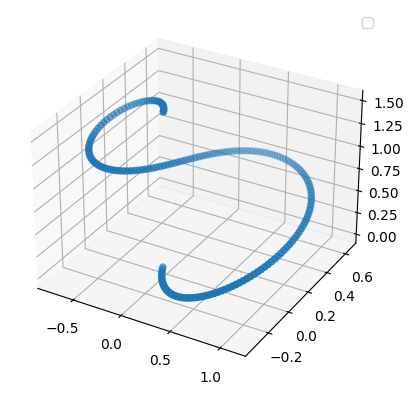

In [48]:
print(pos[-1, 0], pos[-1, 1])
ax = plt.axes(projection='3d')
ax.scatter3D(pos[:,0], pos[:,1], pos[:,2], cmap='viridis')
# ax.scatter3D(pos2[:,0], pos2[:,1], pos2[:,2], cmap='viridis', label='group1')
ax.legend()

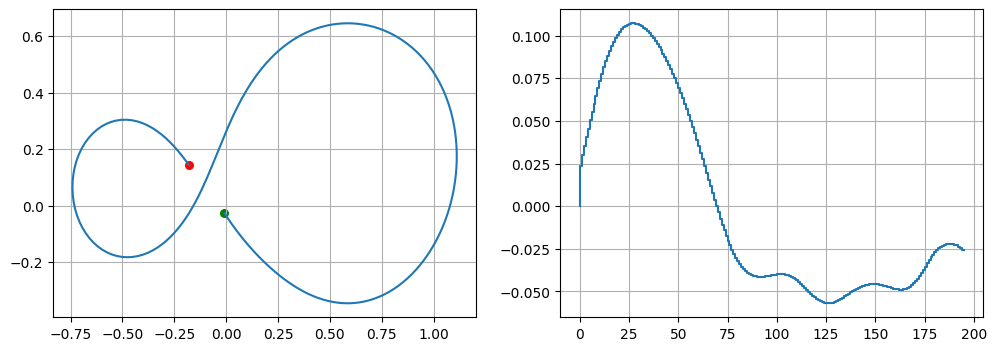

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(pos[0, 0], pos[0, 1], s=30, c='r')
ax[0].scatter(pos[-1, 0], pos[-1, 1], s=30, c='g')
ax[0].plot(pos[:, 0], pos[:, 1])
# ax[0].scatter(pos2[0, 0], pos2[0, 1], s=30, c='r')
# ax[0].scatter(pos2[-1, 0], pos2[-1, 1], s=30, c='g')
# ax[0].plot(pos2[:, 0], pos2[:, 1], '--', label='group1')
ax[0].grid()
# ax[0].legend()

ax[1].step(np.array(range(du.shape[0])), du)
# ax[1].step(np.array(range(du2.shape[0])), du2, '--', label='group1')
ax[1].grid()
# ax[1].legend()


In [6]:
y = [] 
du = [] 

envs_eval = gym.vector.SyncVectorEnv(
    [make_env(1, i, False, 1, 0.99, args) for i in range(10)])
agent = Agent(envs_eval)
agent.load_state_dict(torch.load('./models/shell_1234_1693144865/best_agent.pt'))
# agent.load_state_dict(torch.load('./models/Shell-v0_q_1.0_r_1.0_1234_1688650972/best_agent.pt'))

next_obs_eval, _ = envs_eval.reset() 
returns_eval = [] 
while len(returns_eval) < 10:
    while True:
        y.append(np.array([envs_eval.envs[i].y for i in range(10)]).squeeze())
        du.append(np.array([envs_eval.envs[i].du for i in range(10)]).squeeze())

        # y.append(np.array([envs_eval.envs[i].ysim[envs_eval.envs[i].num_step, :] for i in range(10)]).squeeze())
        # du.append(np.array([envs_eval.envs[i].dusim[envs_eval.envs[i].num_step, :] for i in range(10)]).squeeze())
        
        with torch.no_grad():
            # mean = np.array([envs_eval.envs[i].obs_rms.mean for i in range(10)])
            # var = np.array([envs_eval.envs[i].obs_rms.var for i in range(10)])
            # next_obs_eval = next_obs_eval * np.sqrt(var + 1e-8) + mean 
            # a_eval, _, _, _ = agent.get_action_and_value(torch.FloatTensor(next_obs_eval))
            a_eval = agent.actor_mean(torch.FloatTensor(next_obs_eval))
            next_obs_eval, reward_eval, terminated_eval, truncated_eval, infos_eval = envs_eval.step(a_eval.cpu().numpy())
        done_eval = np.logical_or(terminated_eval, truncated_eval)[0]

        if "final_info" not in infos_eval:
            continue
        for info in infos_eval["final_info"]:
            if info is None:
                continue
            # print(f"eval_episodic_return={info['episode']['r']}")
            returns_eval.append(info["episode"]["r"])
        if done_eval:
            break 
print('----------- EVALUATION ---------------')
print('EPISODE REWARD: ', np.average(returns_eval))
print('--------------------------------------')  

y = np.array(y)
du = np.array(du)
print(y.shape, du.shape)

FileNotFoundError: [Errno 2] No such file or directory: './models/shell_1234_1693144865/best_agent.pt'

In [24]:
y0 = -np.sum((y[1:, 0, :] - 1)**2)
du0 = -np.sum((du[:, 0, :].dot(r.T))**2)
y0 + du0

-17.80950963530679

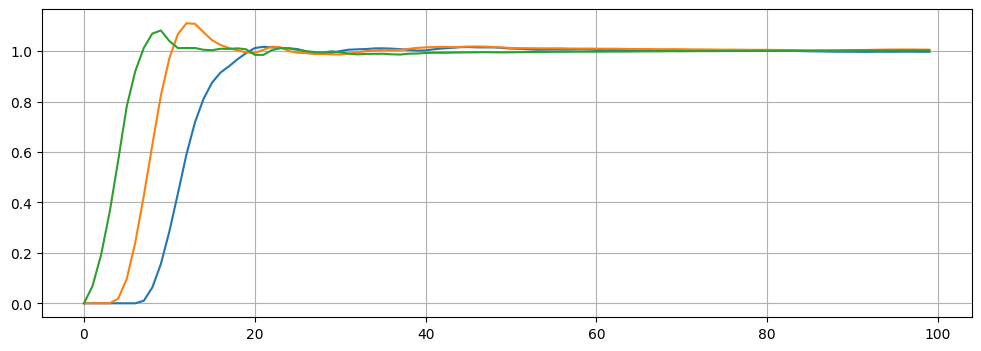

In [26]:
figure = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(y[:, 0, 0])
plt.plot(y[:, 0, 1])
plt.plot(y[:, 0, 2])
# plt.step(np.arange(0, 100, 1), du[:, 0, 0])
# plt.step(np.arange(0, 100, 1), du[:, 0, 1])  # (1, 1)
# plt.step(np.arange(0, 100, 1), du[:, 0, 2])  # (1, 20)
plt.grid()

# figure = plt.figure(figsize=(12, 4), dpi=100)
# plt.step(np.arange(0, 400, 1), du[:, 0, 1])
# plt.grid()
# figure = plt.figure(figsize=(12, 4), dpi=100)
# plt.step(np.arange(0, 400, 1), du[:, 0, 2])
# plt.grid()